# Final Project - Crash Prediction (KAB Prediction i.e. crash injury severity)


The intent of this project is to develop a predictive model to determine the predicted number of KAB crashes at an intersection, based on the input characteristics of that given intersection. 

The data utilized herein is from the Wisconsin Department of Transportation intersection crash datatabase. This has been merged with our highway Meta data document for roadway characteristics in section 7 to the end.



# Setup

In [1]:
#install sklearn_pandas
!pip install sklearn_pandas

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline.

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn_pandas import CategoricalImputer
from collections import Counter
from scipy import sparse, stats
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [4]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding."""
        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [5]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value A,B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Download the data and do some verifications

In [6]:
Inventory="Intersection_Inventory.csv"
df1 = pd.read_csv(Inventory,low_memory=False)

In [7]:
df1.head()

,INT_ID,IX_NAME,GOOGLE_MAP,DOT_REGION,DOR_CNTY_C,CONTROL,LEGCOUNT,LEGS,RMP_TRMNL,ARTYP_FED,...,INJSVR_A,INJSVR_B,INJSVR_C,INJSVR_O,MCOL_ANGL,MCOL_NO,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR
0,IX_01_01021,STH 23 & 2nd Ln,"https://maps.google.com/?q=43.649717,-89.636106",NC,1.0,TWSC,3.0,T,False,RURAL,...,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
1,IX_01_01022,STH 23 & CTH XX,"https://maps.google.com/?q=43.649821,-89.627976",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IX_01_01023,STH 23 & CTH G,"https://maps.google.com/?q=43.649956,-89.654334",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IX_01_01024,STH 23 & 4th Dr,"https://maps.google.com/?q=43.650073,-89.660323",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IX_01_01025,STH 23 & 4th Dr,"https://maps.google.com/?q=43.650245,-89.669544",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adjust the skew angle so that it is all in terms of 0 to 90 degrees.

In [8]:
df1.loc[df1['SKEW_ANGLE'] >= 90, 'SKEW_ANGLE'] = df1['SKEW_ANGLE']- 90
df1.loc[df1['SKEW_ANGLE'] == 90, 'SKEW_ANGLE'] = 0
df1.loc[df1['SKEW_ANGLE'] == -1, 'SKEW_ANGLE'] = 0

Drop unnecssary information.

In [9]:
df1.drop(['MAJOR_INDC','MAJOR_PDP','MAJOR_WID','MINOR_INDC','LIGHTING','COMMENTS',
          'MINOR_PDP','MINOR_WID','MAJOR_SRC','MINOR_SRC','MAJ_1_LTL','MINOR_ST',
          'MAJ_2_LTL','MAJ_2_RTL','MAJOR_ST','MAJ_1_RTL','COMMENTS.1', 'SIDE_CLASS']
         ,axis=1,inplace=True)
df1.drop([13891], axis=0, inplace=True)

The data has blanks where there were zero crashes. Fill in the blanks so that the data is complete. Fill in median values where listed as -1 to 0 as thre is no median.

In [10]:
df1['CRSH_COUNT'].fillna(0,inplace=True)
df1['MEDIAN_FT'].replace(to_replace=-1, value=0, inplace=True)
df1.fillna(0,inplace=True)

reduce number of median categores by dividing by 10.

In [11]:
# Divide by 10 to limit the number of Median_FT values
df1["MEDIAN_FT"] = np.ceil(df1["MEDIAN_FT"] / 10)
# Label those above 10 as 10
df1["MEDIAN_FT"].where(df1["MEDIAN_FT"] < 10, 10.0, inplace=True)

In [12]:
df1['MEDIAN_FT'].value_counts()

0.0     13560
3.0       252
2.0        41
4.0        25
5.0         8
10.0        2
6.0         1
8.0         1
7.0         1
Name: MEDIAN_FT, dtype: int64

In [13]:
df1.describe()

,DOR_CNTY_C,LEGCOUNT,SKEW_ANGLE,MAJ_LNS,MIN_LNS,MEDIAN_FT,MAJOR_AADT,MINOR_AADT,CRSH_COUNT,INJSVR_K,INJSVR_A,INJSVR_B,INJSVR_C,INJSVR_O,MCOL_ANGL,MCOL_NO,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR
count,13891.000000,13891.0,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000
mean,36.455403,3.0,64.625801,1.079440,0.024188,0.073357,4359.554172,382.516737,1.589086,0.009143,0.051760,0.151465,0.166583,1.210136,0.181196,0.908574,0.322799,0.048089,0.095314,0.033115
std,20.622918,0.0,31.898192,0.228399,0.153639,0.487884,3348.898442,740.569022,2.388485,0.095182,0.238453,0.446998,0.530463,1.848892,0.687695,1.387849,0.924764,0.240272,0.391211,0.191385
min,1.000000,3.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,3.0,57.000000,1.000000,0.000000,0.000000,1912.000000,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,3.0,81.000000,1.000000,0.000000,0.000000,3596.000000,254.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,3.0,87.000000,1.000000,0.000000,0.000000,5790.000000,345.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,72.000000,3.0,89.000000,3.000000,1.000000,10.000000,37242.000000,36372.000000,54.000000,1.000000,4.000000,6.000000,10.000000,37.000000,20.000000,20.000000,19.000000,6.000000,9.000000,3.000000


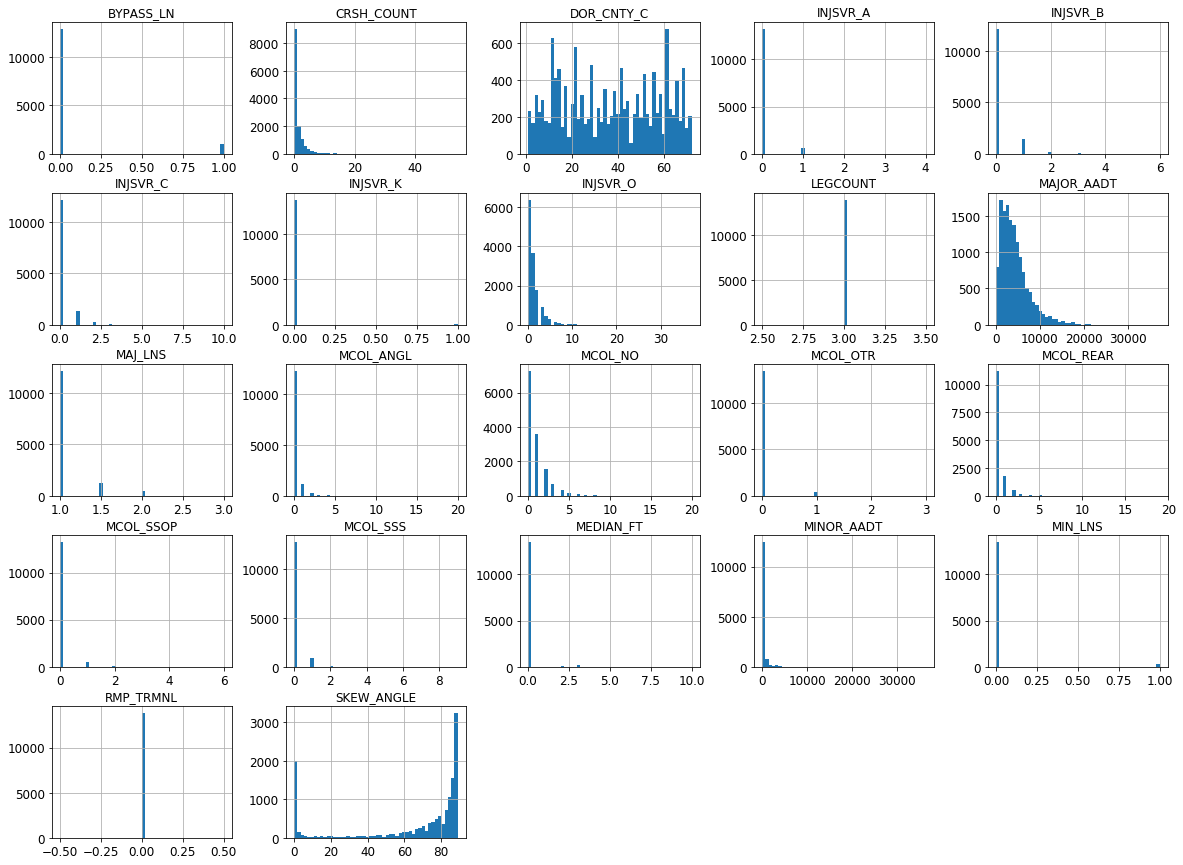

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
df1.hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
df1["CRSH_COUNT"].value_counts().head()

0.0    5399
1.0    3636
2.0    2002
3.0    1108
4.0     607
Name: CRSH_COUNT, dtype: int64

(array([  5.39900000e+03,   3.63600000e+03,   2.00200000e+03,
          1.10800000e+03,   6.07000000e+02,   3.89000000e+02,
          2.17000000e+02,   1.51000000e+02,   9.40000000e+01,
          6.40000000e+01,   5.80000000e+01,   3.80000000e+01,
          2.80000000e+01,   2.30000000e+01,   1.80000000e+01,
          7.00000000e+00,   9.00000000e+00,   7.00000000e+00,
          1.00000000e+01,   3.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

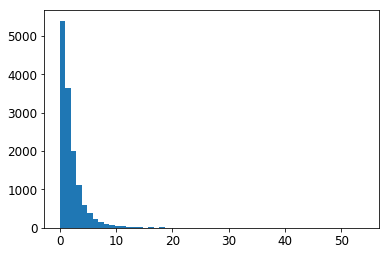

In [16]:
plt.hist(df1['CRSH_COUNT'], bins=55)

In [17]:
# In the column 'GOOGLE_MAP', extract ##.###### in the strings
df1['LAT'] = df1['GOOGLE_MAP'].str.extract('(\d\d\.\d\d\d\d)', expand=True).astype('float')
df1['LON'] = df1['GOOGLE_MAP'].str.extract('(-\d\d\.\d\d\d\d)', expand=True).astype('float')
df1.drop(['GOOGLE_MAP'], axis=1, inplace=True)

In [18]:
df1.head()

,INT_ID,IX_NAME,DOT_REGION,DOR_CNTY_C,CONTROL,LEGCOUNT,LEGS,RMP_TRMNL,ARTYP_FED,SKEW_ANGLE,...,INJSVR_C,INJSVR_O,MCOL_ANGL,MCOL_NO,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR,LAT,LON
0,IX_01_01021,STH 23 & 2nd Ln,NC,1.0,TWSC,3.0,T,False,RURAL,73.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,43.6497,-89.6361
1,IX_01_01022,STH 23 & CTH XX,NC,1.0,TWSC,3.0,T,False,RURAL,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.6498,-89.6279
2,IX_01_01023,STH 23 & CTH G,NC,1.0,TWSC,3.0,T,False,RURAL,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.6499,-89.6543
3,IX_01_01024,STH 23 & 4th Dr,NC,1.0,TWSC,3.0,T,False,RURAL,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.6500,-89.6603
4,IX_01_01025,STH 23 & 4th Dr,NC,1.0,TWSC,3.0,T,False,RURAL,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.6502,-89.6695


## Explore and Visualize Data

In [19]:
df1['MINOR_AADT'].value_counts().head()

123.0    2251
254.0    2057
108.0    1935
110.0     897
287.0     597
Name: MINOR_AADT, dtype: int64

Change 0 AADT values to the median value in Major and Minor AADT column.

In [20]:
min_adt_med =  df1['MINOR_AADT'].median()
df1['MINOR_AADT'].replace(to_replace=0, value= min_adt_med, inplace=True)

df1 = df1[df1.MAJOR_AADT != 0].copy()

Develop a correlation matrix and plot it to find out what the data looks like when paired with the higest correlated variables.

In [21]:
corr_matrix = df1.corr()
corr_matrix["CRSH_COUNT"].sort_values(ascending=False)

CRSH_COUNT    1.000000
INJSVR_O      0.947576
MCOL_NO       0.733423
MCOL_REAR     0.660793
MCOL_ANGL     0.627780
INJSVR_C      0.602756
INJSVR_B      0.535609
MCOL_SSS      0.490248
MAJOR_AADT    0.465677
MCOL_SSOP     0.354030
MINOR_AADT    0.351578
INJSVR_A      0.280574
MCOL_OTR      0.267206
MAJ_LNS       0.254128
LON           0.153483
BYPASS_LN     0.148227
MIN_LNS       0.124532
INJSVR_K      0.112906
MEDIAN_FT     0.111066
DOR_CNTY_C    0.077679
SKEW_ANGLE   -0.012793
LAT          -0.172676
LEGCOUNT           NaN
RMP_TRMNL          NaN
Name: CRSH_COUNT, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a160b4710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1671a6d8>]], dtype=object)

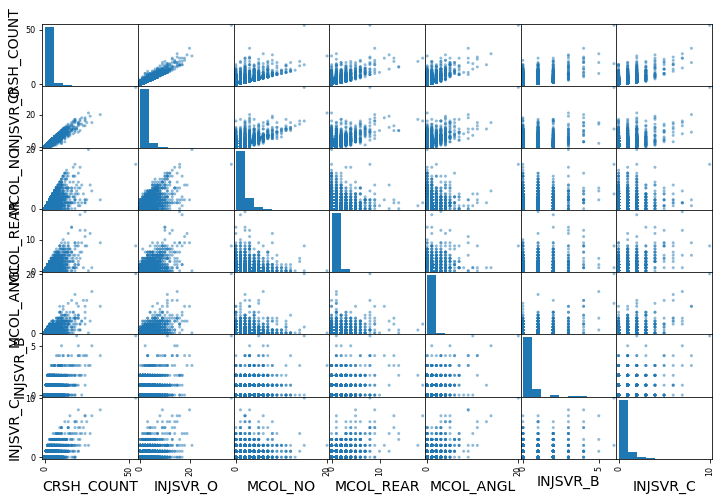

In [22]:
from pandas.plotting import scatter_matrix
# Top six correlated inputs with CRSH_COUNT_CAT (Excluding crash count as that will be removed later) 
attributes = ['CRSH_COUNT', 'INJSVR_O', 'MCOL_NO','MCOL_REAR','MCOL_ANGL',
              'INJSVR_B','INJSVR_C']
scatter_matrix(df1[attributes], figsize=(12, 8))

### Create new variables based on crash per million entering vehicles
https://safety.fhwa.dot.gov/local_rural/training/fhwasaxx1210/s3.cfm

In [23]:
df1["TOTAL_AADT"] = df1["MAJOR_AADT"]+df1["MINOR_AADT"]
df1["CRSH_RT"] = (df1["CRSH_COUNT"]*1000000)/(365*df1["TOTAL_AADT"])

In [24]:
df1.sort_values(by=['CRSH_RT', 'TOTAL_AADT'], ascending=[False, True])

,INT_ID,IX_NAME,DOT_REGION,DOR_CNTY_C,CONTROL,LEGCOUNT,LEGS,RMP_TRMNL,ARTYP_FED,SKEW_ANGLE,...,MCOL_ANGL,MCOL_NO,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR,LAT,LON,TOTAL_AADT,CRSH_RT
4484,IX_22_03859,STH 133 & CTH K,SW,22.0,TWSC,3.0,T+Driveway,False,RURAL,65.0,...,0.0,12.0,0.0,0.0,0.0,0.0,43.0687,-90.8368,887.0,37.065065
6843,IX_36_03551,USH 10 & Village Dr,NE,36.0,TWSC,3.0,T+Driveway,False,RURAL,83.0,...,0.0,4.0,0.0,0.0,0.0,0.0,44.1531,-87.7473,364.0,30.106879
3836,IX_20_02808,USH 45 & E 9th St,NE,20.0,TWSC,3.0,T,False,URBAN,50.0,...,1.0,0.0,5.0,0.0,1.0,0.0,43.7687,-88.4303,687.0,27.915695
6609,IX_35_01818,STH 107 & Swede Rd,NC,35.0,TWSC,3.0,T,False,RURAL,36.0,...,0.0,6.0,0.0,0.0,0.0,0.0,45.2055,-89.7347,596.0,27.581135
1723,IX_11_02241,STH 78 & Dahlke Dr,SW,11.0,TWSC,3.0,T,False,RURAL,86.0,...,0.0,7.0,0.0,0.0,0.0,0.0,43.4197,-89.6006,953.0,20.123906
3844,IX_20_02964,USH 45 & 5th St (1),NE,20.0,TWSC,3.0,T,False,URBAN,89.0,...,0.0,2.0,1.0,0.0,2.0,0.0,43.7727,-88.4445,687.0,19.939782
11895,IX_62_02395,STH 131 & New Heisel Rd,SW,62.0,TWSC,3.0,T,False,RURAL,85.0,...,0.0,5.0,0.0,0.0,0.0,0.0,43.6393,-90.5966,689.0,19.881902
8585,IX_44_07153,STH 187 & Deerview Rd,NE,44.0,TWSC,3.0,T,False,RURAL,80.0,...,0.0,3.0,0.0,0.0,0.0,0.0,44.5353,-88.5492,508.0,16.179484
6283,IX_33_01651,STH 78 & Round Rd,SW,33.0,TWSC,3.0,T,False,RURAL,31.0,...,0.0,3.0,0.0,0.0,0.0,0.0,42.6395,-89.9162,509.0,16.147698
2580,IX_13_15218,STH 89 & CTH TV,SW,13.0,TWSC,3.0,T,False,RURAL,81.0,...,0.0,10.0,0.0,0.0,0.0,0.0,43.2123,-89.0086,1713.0,15.993730


### Create new variable based on combined injury crashes (K,A,B) and also one based on (K,A,B) Ratio.

In [25]:
df1["KAB_CRASH"] = (df1["INJSVR_K"]+df1["INJSVR_A"]+df1["INJSVR_B"])
df1["KAB_RATIO"] = (df1["KAB_CRASH"]/df1["CRSH_COUNT"])
df1.fillna(0,inplace=True)
#df1["KABC_CRASH"] = (df1["INJSVR_K"]+df1["INJSVR_A"]+df1["INJSVR_B"]+df1["INJSVR_C"])

In [26]:
df1.describe()

,DOR_CNTY_C,LEGCOUNT,SKEW_ANGLE,MAJ_LNS,MIN_LNS,MEDIAN_FT,MAJOR_AADT,MINOR_AADT,CRSH_COUNT,INJSVR_K,...,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR,LAT,LON,TOTAL_AADT,CRSH_RT,KAB_CRASH,KAB_RATIO
count,13877.000000,13877.0,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,...,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000,13877.000000
mean,36.469410,3.0,64.616848,1.079340,0.024213,0.073431,4363.952367,389.123081,1.588456,0.009152,...,0.322692,0.048137,0.094689,0.033148,44.287368,-89.884995,4753.075449,0.989232,0.212366,0.083648
std,20.623075,0.0,31.902764,0.228208,0.153715,0.488125,3347.721795,738.305436,2.387912,0.095230,...,0.924857,0.240388,0.388986,0.191479,1.094567,1.356480,3579.216815,1.488595,0.546297,0.226412
min,1.000000,3.0,0.000000,1.000000,0.000000,0.000000,65.000000,41.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,42.493400,-92.801800,190.000000,0.000000,0.000000,0.000000
25%,17.000000,3.0,57.000000,1.000000,0.000000,0.000000,1914.000000,123.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,43.354800,-90.927300,2175.000000,0.000000,0.000000,0.000000
50%,37.000000,3.0,81.000000,1.000000,0.000000,0.000000,3600.000000,254.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,44.196300,-89.812200,3966.000000,0.583086,0.000000,0.000000
75%,55.000000,3.0,87.000000,1.000000,0.000000,0.000000,5800.000000,345.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,45.147300,-88.738900,6247.000000,1.419915,0.000000,0.000000
max,72.000000,3.0,89.000000,3.000000,1.000000,10.000000,37242.000000,36372.000000,54.000000,1.000000,...,19.000000,6.000000,9.000000,3.000000,46.897400,-86.986700,72744.000000,37.065065,7.000000,1.000000


### Now that we have rates and KAB, use those to do further analysis and remove the individual injury columns.

In [27]:
df_sum_inj = df1.drop(["INJSVR_K", "INJSVR_B","INJSVR_A","INJSVR_C","INJSVR_O"], axis=1)

### What is the correlation using different crash rate and crash count values?

In [28]:
corr_matrix = df_sum_inj.corr()
corr_matrix["CRSH_RT"].sort_values(ascending=False)

CRSH_RT       1.000000
MCOL_NO       0.606871
CRSH_COUNT    0.538907
KAB_CRASH     0.321500
MCOL_ANGL     0.201326
MCOL_REAR     0.199721
KAB_RATIO     0.163292
MCOL_SSS      0.160447
MCOL_SSOP     0.159984
MCOL_OTR      0.106193
MINOR_AADT    0.041524
BYPASS_LN     0.040059
LON           0.026544
DOR_CNTY_C    0.020928
MAJ_LNS       0.007317
SKEW_ANGLE   -0.026638
MEDIAN_FT    -0.028120
MIN_LNS      -0.028145
TOTAL_AADT   -0.065688
LAT          -0.071615
MAJOR_AADT   -0.079388
LEGCOUNT           NaN
RMP_TRMNL          NaN
Name: CRSH_RT, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15e80fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a164b3eb8>]], dtype=object)

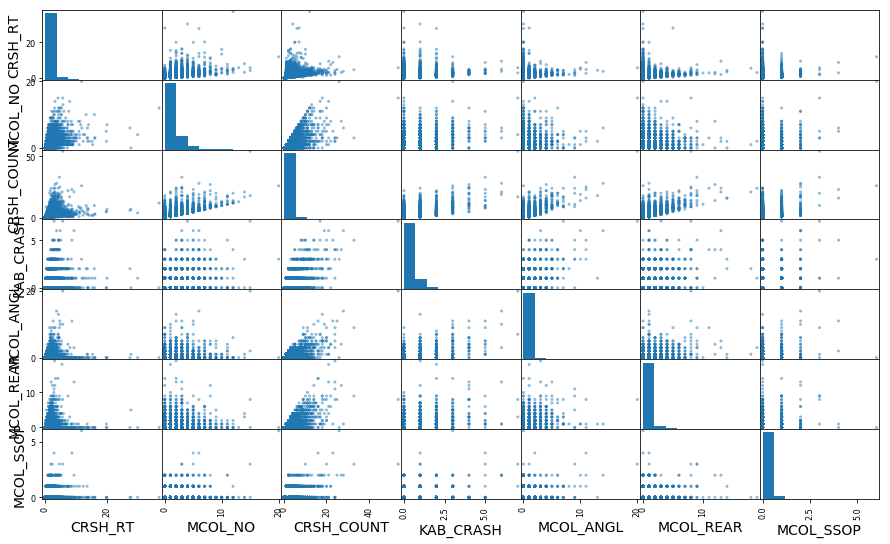

In [29]:
from pandas.plotting import scatter_matrix
# Top six correlated inputs with CRSH_RT, ignore other crash rates.
attributes = ['CRSH_RT','MCOL_NO','CRSH_COUNT','KAB_CRASH','MCOL_ANGL','MCOL_REAR',
              'MCOL_SSOP']
scatter_matrix(df_sum_inj[attributes], figsize=(15, 9))

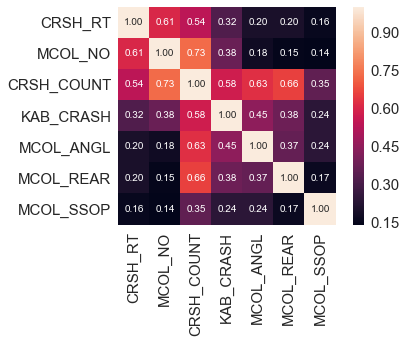

In [30]:
cm = np.corrcoef(df_sum_inj[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

### What is the correlation using KAB_CRASH?

In [31]:
corr_matrix = df_sum_inj.corr()
corr_matrix["KAB_CRASH"].sort_values(ascending=False)

KAB_CRASH     1.000000
KAB_RATIO     0.691351
CRSH_COUNT    0.580333
MCOL_ANGL     0.449271
MCOL_REAR     0.382556
MCOL_NO       0.375820
CRSH_RT       0.321500
TOTAL_AADT    0.273626
MCOL_SSS      0.259083
MAJOR_AADT    0.241737
MCOL_SSOP     0.239342
MINOR_AADT    0.230387
MCOL_OTR      0.224812
MAJ_LNS       0.147803
BYPASS_LN     0.123002
LON           0.073531
MIN_LNS       0.061486
MEDIAN_FT     0.057997
DOR_CNTY_C    0.050192
SKEW_ANGLE   -0.017755
LAT          -0.104676
LEGCOUNT           NaN
RMP_TRMNL          NaN
Name: KAB_CRASH, dtype: float64

/Users/brentmatthews/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c7035c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1dbeada0>]], dtype=object)

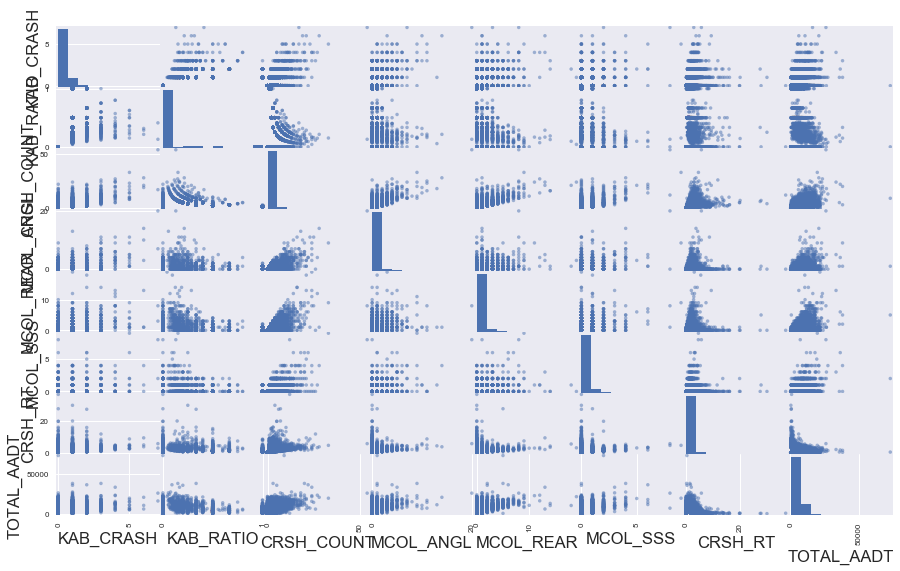

In [32]:
from pandas.tools.plotting import scatter_matrix
# Top six correlated inputs with CRSH_RT, ignore other crash rates.
attributes = ['KAB_CRASH','KAB_RATIO','CRSH_COUNT','MCOL_ANGL','MCOL_REAR','MCOL_SSS',
             'CRSH_RT','TOTAL_AADT']
scatter_matrix(df_sum_inj[attributes], figsize=(15, 9))

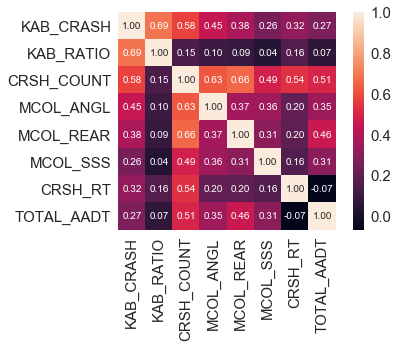

In [33]:
cm = np.corrcoef(df_sum_inj[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

Plot the top correlation plot, Crash Count vs. KAB Crashes. 

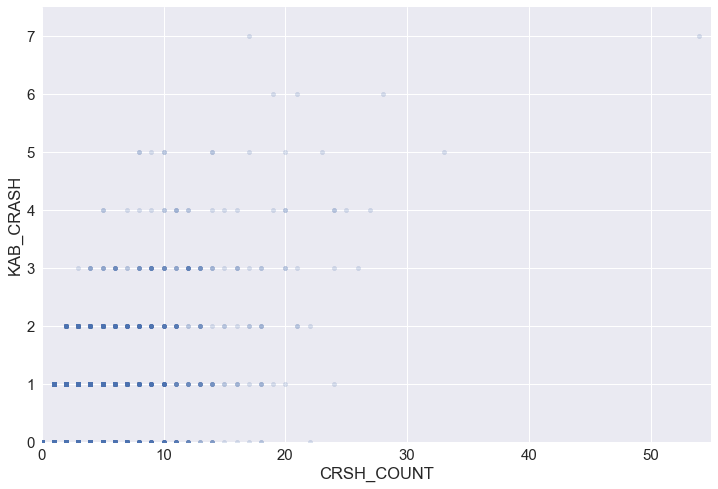

In [34]:
df_sum_inj.plot(kind="scatter", x="CRSH_COUNT", y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 55, 0, 7.5])
plt.show()

Look at the next correlation variable, MCOL_ANGL.

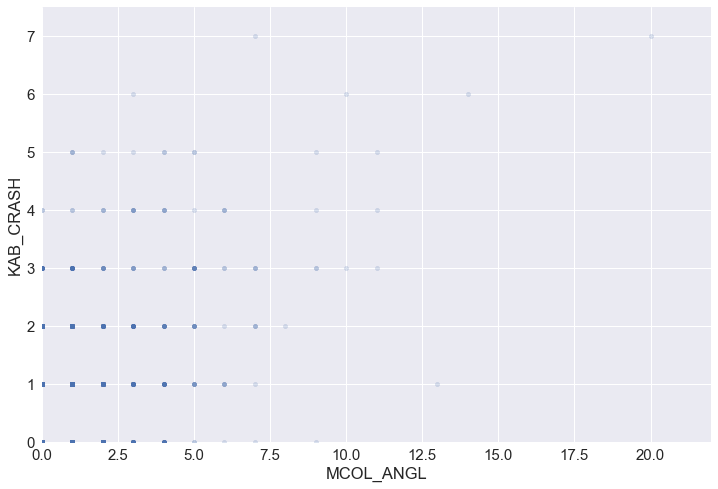

In [35]:
df_sum_inj.plot(kind="scatter", x='MCOL_ANGL', y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 22, 0, 7.5])
plt.show()

### Plot of crashes throughout Wisconsin

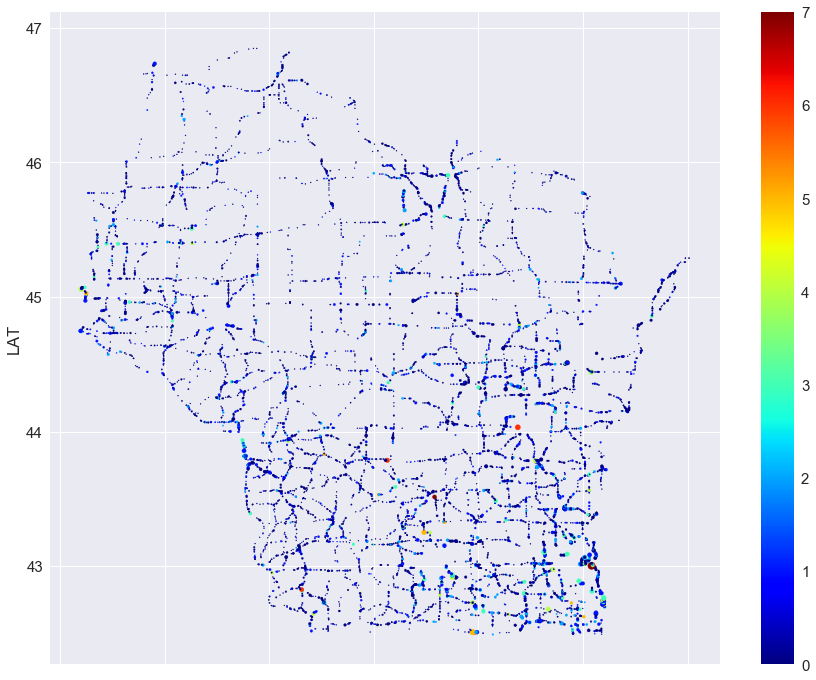

In [36]:
df_sum_inj.plot(kind="scatter", x="LON", y="LAT",c=df_sum_inj['KAB_CRASH'],
                cmap=plt.get_cmap("jet"), s=df_sum_inj['CRSH_COUNT'],colorbar=True,
                alpha = 1,figsize=(15, 12))

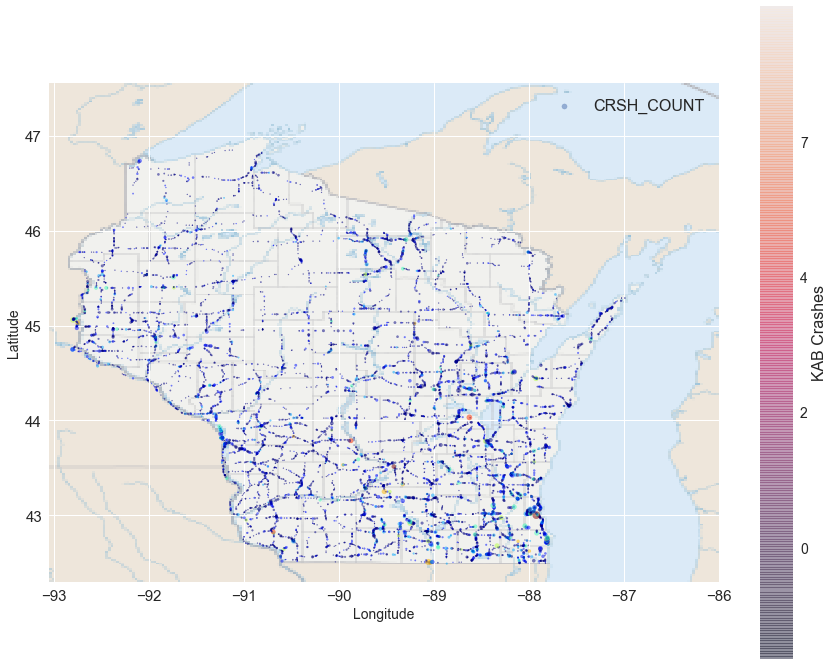

In [37]:
import matplotlib.image as mpimg
wisconsin_img=mpimg.imread('./images/wisconsin.png')

ax = df_sum_inj.plot(kind="scatter", x="LON", y="LAT",c=df_sum_inj['KAB_CRASH'],
                     cmap=plt.get_cmap("jet"), 
                     s=df_sum_inj['CRSH_COUNT'],
                     label="CRSH_COUNT",
                     colorbar=False,
                     alpha = 0.5,
                     figsize=(15, 12)
                    )

plt.imshow(wisconsin_img, extent=[-93.05, -86.00, 42.30, 47.55], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

crashes = df_sum_inj["KAB_CRASH"]
tick_values = np.linspace(crashes.min(), crashes.max(), 4)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["%d"%((v)) for v in tick_values], fontsize=14)
cbar.set_label('KAB Crashes', fontsize=16)

plt.legend(fontsize=16)
plt.show()

# Training

## Pipeline Using Basic Features

In [38]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ["LEGCOUNT","MAJ_LNS","MIN_LNS","MAJOR_AADT","MINOR_AADT",
               "TOTAL_AADT","CRSH_RT", "CRSH_COUNT","MCOL_ANGL","MCOL_REAR",
               "MCOL_NO", "MCOL_SSS", "MCOL_SSOP","MCOL_OTR", "LON", 
               "MEDIAN_FT", "SKEW_ANGLE", "LAT", "KAB_RATIO"]

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])

# Identify the categorical features we wish to consider.
cat_attribs = ["CONTROL","LEGS","RMP_TRMNL","ARTYP_FED","BYPASS_LN",
               "SHARED_LT","MEDIAN_TYP"]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore")),
        ])

# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline)])

## Train/Test Split

Reorder the data so it is easier to select subset of columns to use for train/test.

In [39]:
df_sum_inj = df_sum_inj[['INT_ID','IX_NAME','DOT_REGION', 'DOR_CNTY_C', 'CONTROL', 'LEGCOUNT', 
                         'LEGS', 'RMP_TRMNL','ARTYP_FED','SKEW_ANGLE','MAJ_LNS','MIN_LNS','BYPASS_LN',
                         'SHARED_LT', 'MEDIAN_TYP', 'MEDIAN_FT','MAJOR_AADT', 'MINOR_AADT',
                         'CRSH_COUNT', 'MCOL_ANGL', 'MCOL_NO', 'MCOL_REAR', 'MCOL_SSOP',
                         'MCOL_SSS', 'MCOL_OTR', 'LAT', 'LON', 'TOTAL_AADT', 'CRSH_RT',
                         'KAB_RATIO','KAB_CRASH']]

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [40]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = df_sum_inj.iloc[:,3:30]
y = df_sum_inj["KAB_CRASH"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

X_train (11101, 27) y_train (11101,)
X_test (2776, 27) y_test (2776,)


# Baseline Linear Regression, SVR, Ridge

In [42]:
X_train = full_pipeline.fit_transform(X_train)
print(X_train.shape)

X_test = full_pipeline.transform(X_test)
print(X_test.shape)

(11101, 38)
(2776, 38)


In [43]:
print(X_train[0])

[ 0.         -0.34638359 -0.15818686 -1.08326256 -0.42349086 -1.10124719
 -0.67601327 -0.65863222 -0.25733635 -0.35219662 -0.64595035 -0.24232518
 -0.19991656 -0.17127436 -0.97516555 -0.15203425 -1.4777806   0.79331258
 -0.36687001  1.          1.          0.          0.          0.          1.
  1.          0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.        ]


In [44]:
# Imports for metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
                       
# Convert a number to a percent.    
def pct(x):
    return round(100*x,1)

# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train MSE","Train RMSE","Test MSE","Test RMSE","p-value", 
                                "Train Time(s)", "Test Time(s)", "Experiment description"])

## Baseline Linear Regression

In [45]:
# This Linear Regression model will serve as a baseline for comparison. 
# It will not be tuned, nor will it use crossfold validation.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit the training data
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict the outcomes
linreg_preds_train = linreg.predict(X_train)
linreg_preds = linreg.predict(X_test)

#MSE
mse_train = mean_squared_error(y_train, linreg_preds_train)
mse_test = mean_squared_error(y_test, linreg_preds)
print(linreg_preds)
print ('MSE train: %.3f, test: %.3f' % (
      mean_squared_error(y_train, linreg_preds_train),
      mean_squared_error(y_test, linreg_preds)))
print ('RMSE train: %.3f, test: %.3f' % (
      np.sqrt(mean_squared_error(y_train, linreg_preds_train)),
      np.sqrt(mean_squared_error(y_test, linreg_preds))))

[ 0.00378418 -0.05950928  0.00924683 ..., -0.03997803  0.18560791
  0.07232666]
MSE train: 0.083, test: 3848233259080794624.000
RMSE train: 0.289, test: 1961691428.100


In [46]:
print(linreg.fit(X_train, y_train).intercept_)
print(linreg.fit(X_train, y_train).coef_)

-161581758605.0
[ -2.70240172e-18   2.79520152e-02   1.20762813e-01  -7.31559023e+10
  -1.65472866e+10   7.83245352e+10  -3.13102703e-02   3.20483106e+12
  -9.34576410e+11  -1.21221956e+12  -1.87318435e+12  -5.26860659e+11
  -3.18104994e+11  -2.45890477e+11   1.25122070e-02   1.78222656e-02
   1.46484375e-03   9.94873047e-03   3.26210022e-01  -4.65876020e+10
  -1.03357126e+11  -1.03357126e+11  -1.03357126e+11  -1.03357126e+11
   3.62197553e+08   2.63711470e+11   2.63711470e+11  -6.17570378e+10
  -6.17570378e+10   2.53977916e+10   2.53977916e+10   8.38120659e+10
   8.38120659e+10   8.38120659e+10   8.38120659e+10   8.38120659e+10
   8.38120659e+10   8.38120659e+10]


In [47]:
# Use crossval to get array of differnt scores
# Predict the outcomes
linreg_preds_train = linreg.predict(X_train)
linreg_preds = linreg.predict(X_test)

cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
linreg_scores = cross_val_score(linreg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
linreg_testscores = cross_val_score(linreg, X_test, y_test, cv=cv, scoring='neg_mean_squared_error')

lr_score_train = linreg_scores.mean()
lr_score_test  = linreg_testscores.mean()

In [48]:
results.loc[0] = ["Linear Baseline", lr_score_train,np.sqrt(-lr_score_train),
                  lr_score_test, np.sqrt(-lr_score_test),
                  "---", "< 1s", "< 1s", "Untuned LinearRegression"]
results

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression


WOW! The test means squared error is extremely high. How is this possible. Basically, there are far to many variables that have little to no correlation wiht the overall KAB crash numbers. Let's look at different models to see if there is a any better outcomes. 

## Crossval SVR

In [49]:
from sklearn.svm import SVR

poly_kernel_svm_reg = SVR()
poly_kernel_svm_reg.fit(X_train, y_train)

# Predict the test outcomes
poly_kernel_svm_train = poly_kernel_svm_reg.predict(X_train)
poly_kernel_svm_preds = poly_kernel_svm_reg.predict(X_test)

cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
poly_kernel_svm_reg_scores = cross_val_score(poly_kernel_svm_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
poly_kernel_svm_reg_testscores = cross_val_score(poly_kernel_svm_reg, X_test, y_test, cv=cv, scoring='neg_mean_squared_error')

poly_score_train = poly_kernel_svm_reg_scores.mean()
poly_score_test  = poly_kernel_svm_reg_testscores.mean()

In [50]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, poly_kernel_svm_reg_scores)

In [51]:
results.loc[1] = ["SVR Crossval", -poly_score_train, np.sqrt(-poly_score_train),
                  -poly_score_test, np.sqrt(-poly_score_test),
                  round(p_value,3), "< 1s", "< 1s", "CV SupportVectorRegressor"]
results

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor


The support vector regressor with 30 fold crossvalidation gave us much better scores for the train and test MSE. 

## Crossval Ridge

In [52]:
# This Ridge Regression model will serve as a baseline for comparison. 
# It will not be tuned, nor will it use crossfold validation.
from sklearn.linear_model import Ridge

# Fit the training data
ridgereg = Ridge()
ridgereg.fit(X_train, y_train)

# Predict the test outcomes
#ridgereg_preds_train = ridgereg.predict(X_train)
#ridgereg_preds = ridgereg.predict(X_test)

# Score the training and test predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
ridgereg_scores = cross_val_score(ridgereg, X_train, y_train, cv=cv,scoring='neg_mean_squared_error')
ridgereg_score_train = ridgereg_scores.mean()

ridgereg_scores_tst = cross_val_score(ridgereg, X_test, y_test, cv=cv,scoring='neg_mean_squared_error')
ridgereg_score_test = ridgereg_scores_tst.mean()

In [53]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, ridgereg_scores)

In [54]:
results.loc[2] = ["Ridge Crossval", -ridgereg_score_train,np.sqrt(-ridgereg_score_train),
                  -ridgereg_score_test, np.sqrt(-ridgereg_score_test),
                  round(p_value,3), "< 1s", "< 1s", "CV RidgeRegression"]
results

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression


## Finetune model/pipeline hyperparameters

Let’s assume at this point that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that:

* GridSearch
* RandomSearch

### Finetune via GridSearch

In the following the `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
`n_estimators` and `max_features` hyperparameter values specified in the first dict
(don’t worry about what these hyperparameters mean for now; they will be explained
in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the `bootstrap` hyperparameter set to `False` instead of
`True` (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

#### GridSearch Random Forest

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from time import time

param_grid = [
    #try 12 (4×3) combinations with bootstrap set as False
    {'bootstrap': [False],'n_estimators': [20,25,30,35], 'max_features': [25,30,35]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+12)*5=120 rounds of training 
grid_search_rnd = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rnd.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_rnd.best_score_

# Best estimator fitting time
t0 = time()
grid_search_rnd.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = grid_search_rnd.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(grid_search_rnd.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [151]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_rnd.best_estimator_.get_params()
print(best_parameters)

# Record the results
results.loc[3] = ["Tuned RandomForest", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 30, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 35, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.6313e+20,1.905598e+10,-6.46788e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,0.0442474,2.103506e-01,0.0549676,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,0.0833409,2.886882e-01,0.083404,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,0.0833049,2.886259e-01,0.728575,8.535663e-01,0.005,3.62,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,0.0833608,2.887226e-01,-0.728388,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,0.0849943,2.915379e-01,-0.72495,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,0.0442474,2.103506e-01,-0.904248,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,0.0057903,7.609401e-02,-0.996204,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,0.0833049,2.886259e-01,-0.728575,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,0.180576,4.249422e-01,0.189056,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


#### GridSearch Ridge Regression

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from time import time

param_grid = [
    # try 27 (3×3x3) combinations of hyperparameters
    {'alpha': ('0.00001','0.00002','0.000009'), 'tol': (1000.0,2000.0,500.0),
     'max_iter': (50000,10000,5000)}]

ridge_reg = Ridge(random_state=42)
# train across 5 folds, that's a total of (27)*5=135 rounds of training 
grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_ridge.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_ridge.best_score_

# Best estimator fitting time
t0 = time()
grid_search_ridge.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = grid_search_ridge.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(grid_search_ridge.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [152]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_ridge.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[4] = ["Tuned Ridge", -best_train_accuracy, np.sqrt(-best_train_accuracy),
                  best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'alpha': '0.00002', 'copy_X': True, 'fit_intercept': True, 'max_iter': 50000, 'normalize': False, 'random_state': 42, 'solver': 'auto', 'tol': 1000.0}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.6313e+20,1.905598e+10,-6.46788e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,0.0442474,2.103506e-01,0.0549676,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,0.0833409,2.886882e-01,0.083404,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,0.0833049,2.886259e-01,0.728575,8.535663e-01,0.005,3.62,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,0.0833049,2.886259e-01,0.728575,8.535663e-01,0.005,3.62,0.01,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,0.0849943,2.915379e-01,-0.72495,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,0.0442474,2.103506e-01,-0.904248,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,0.0057903,7.609401e-02,-0.996204,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,0.0833049,2.886259e-01,-0.728575,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,0.180576,4.249422e-01,0.189056,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


#### GridSearch Stochastic GD

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from time import time

param_grid = [
    # try 24 (6×2x2) combinations of hyperparameters
    {'alpha': (0.000001, 0.0000001), 'penalty': ('l1', 'l2'),
     'loss': ('squared_loss', 'huber'),'max_iter': (20,30)}]          

SGD_reg = SGDRegressor(random_state=42)
# train across 5 folds, that's a total of (24)*5=120 rounds of training 
grid_search = GridSearchCV(SGD_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           refit='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search.best_score_

# Best estimator fitting time
t0 = time()
grid_search.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = grid_search.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [60]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[5] = ["Tuned SGD", -best_train_accuracy, np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'alpha': 1e-06, 'average': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_loss', 'max_iter': 30, 'n_iter': None, 'penalty': 'l1', 'power_t': 0.25, 'random_state': 42, 'shuffle': True, 'tol': None, 'verbose': 0, 'warm_start': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."


#### GridSearch Support Vector Regressor

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from time import time

param_grid = [
    # try 3 (1x3) combinations of hyperparameters
    {'kernel': ('poly', 'rbf'),'degree': (3,4)}
]          

SV_reg = SVR()
# train across 5 folds, that's a total of (24)*5=120 rounds of training 
grid_search_svr = GridSearchCV(SV_reg, param_grid, cv=5, scoring='neg_mean_squared_error',refit='neg_mean_squared_error')

grid_search_svr.fit(X_train, y_train)
                
# Best estimator score
best_train = grid_search_svr.best_score_

# Best estimator fitting time
t0 = time()
grid_search_svr.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = grid_search_svr.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(grid_search_svr.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

In [62]:
# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = grid_search_svr.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[6] = ["Tuned SVR", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy,np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,4.424738e-02,2.103506e-01,-9.042482e-01,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."


### Finetune model using RandomizedSearchCV

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=35),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=15, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

# Best estimator score
best_train = rnd_search.best_score_

# Best estimator fitting time
t0 = time()
rnd_search.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = rnd_search.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

#### Random Search for 15 experiments

In [64]:
"""cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
print(rnd_search.cv_best_estimator_)"""

# Collect the best parameters found by the random search
print("Best Parameters:")
best_parameters = rnd_search.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[7] = ["RandomSearch RndForest", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 28, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 188, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,4.424738e-02,2.103506e-01,-9.042482e-01,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,5.790299e-03,7.609401e-02,-9.962042e-01,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."


### Finetune Ridge model using RandomizedSearchCV

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from random import randrange
from scipy.stats import randint

param_distribs = {
    'alpha': randint(-10, 10),
    'max_iter': randint(low=10000, high=50000),
    'tol': randint(low=100, high=2000),
    }

ridge_reg = Ridge(random_state=42)
rnd_search_rr = RandomizedSearchCV(ridge_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_rr.fit(X_train, y_train)

# Best estimator score
best_train = rnd_search_rr.best_score_

# Best estimator fitting time
t0 = time()
rnd_search_rr.best_estimator_.fit(X_train, y_train)
time_train = round(time() - t0,2)

# Best estimator prediction time
t0 = time()
best_test_accuracy = rnd_search_rr.best_estimator_.score(X_test, y_test)
time_test = round(time() - t0,2)

# Generate 30 training accuracy scores with the best estimator and 30-split CV
best_train_scores = cross_val_score(rnd_search_rr.best_estimator_, X_train, y_train, 
                                    cv=cv, scoring='neg_mean_squared_error')
best_train_accuracy = best_train_scores.mean() #Average MSE

# Conduct t-test with baseline linear (control) and best estimator (experiment)
(t_stat, p_value) = stats.ttest_rel(linreg_scores, best_train_scores)

#### Random Search for 20 experiments

In [66]:
"""cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)"""
    
# Collect the best parameters found by the random search
print("Best Parameters:")
best_parameters = rnd_search_rr.best_estimator_.get_params()

print(best_parameters)

# Record the results
results.loc[8] = ["RandomSearch Ridge", -best_train_accuracy,np.sqrt(-best_train_accuracy),
                  -best_test_accuracy, np.sqrt(best_test_accuracy),
                  round(p_value,3), time_train, time_test, best_parameters]
results

Best Parameters:
{'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': 47194, 'normalize': False, 'random_state': 42, 'solver': 'auto', 'tol': 1582}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,4.424738e-02,2.103506e-01,-9.042482e-01,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,5.790299e-03,7.609401e-02,-9.962042e-01,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,8.330492e-02,2.886259e-01,-7.285754e-01,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."


## Observations

My observation is showing that the Best models are either the Crossvalidated Ridge Regression, Crossvalidated Support Vector Regressor, or the Tuned SGD. These models shows to be better than the baseline Linear Model. Additionally, all of the models results are not different by a significant value. The strange finding here is that the p-value is the same for each model. That could be because the MSE of the original linear regression model was so very high.

The p-value is 0.005, which is below the standard thresholds of 0.05/2 or 0.01/2, so we can reject the null hypothesis and we can say that there is a statistically significant difference between the linear regression baseline and the rest of the models. 

# Input variable importance  (this utilizes the random search - random forest regressor output)

Use the RandomForestRegressor to indicate the relative importance of each
attribute for making accurate predictions:

In [67]:
feature_importances = grid_search_rnd.best_estimator_.feature_importances_
feature_importances

array([  0.00000000e+00,   8.62518645e-05,   7.95794349e-06,
         6.95659627e-04,   3.15814551e-03,   1.77102206e-03,
         3.72575841e-03,   1.25581283e-01,   8.70473286e-03,
         1.58121092e-03,   1.75117136e-03,   9.86106904e-04,
         1.60625460e-03,   2.32583740e-04,   7.88489542e-04,
         2.86894065e-05,   1.70317414e-03,   5.34067625e-04,
         8.46550601e-01,   0.00000000e+00,   4.61649667e-05,
         5.71978794e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.47104348e-05,
         3.14236743e-05,   5.49914300e-05,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.94174160e-05,
         0.00000000e+00,   1.39978186e-05,   1.77367274e-04,
         0.00000000e+00,   6.15686363e-05])

In [68]:
#extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs #+ extra_attribs 
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)

In [69]:
np.array(sortedFeatures)[:, 0]

array(['0.0', '0.0', '7.9579434931e-06', '2.86894065418e-05',
       '8.62518644753e-05', '0.000232583739503', '0.000534067625084',
       '0.000695659626891', '0.000788489542333', '0.000986106904211',
       '0.00158121092036', '0.00160625460254', '0.00170317413982',
       '0.00175117136313', '0.00177102205535', '0.00315814551005',
       '0.00372575841311', '0.00870473286343', '0.125581282625',
       '0.846550601324'],
      dtype='<U32')

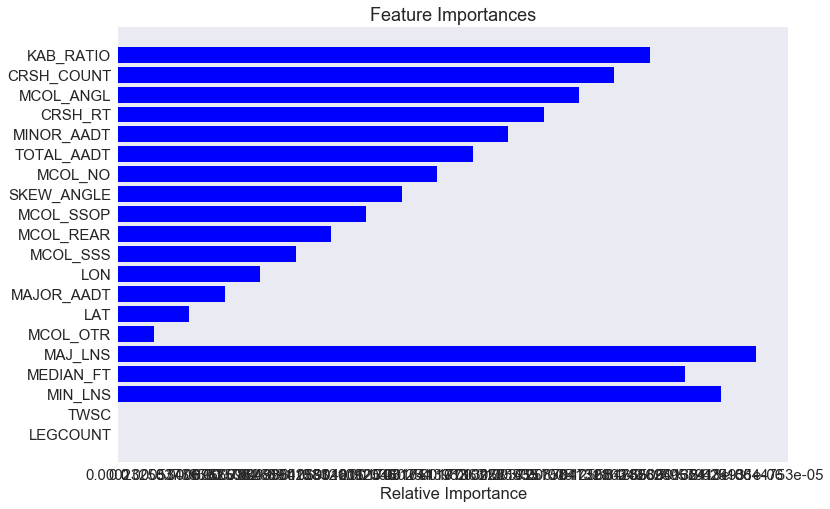

In [70]:
# Plot the feature importances of the forest model
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8)) 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

This plot shows us the the most important value in determining total KAB crashes is LOG_CRSH_COUNT. This is pretty obvious that, given a crash count, there would be a correlation with KAB crashes. 

## Feature Selection

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [72]:
k = 6

Now let's look for the indices of the top k features:

In [73]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 4,  5,  6,  7,  8, 18])

In [74]:
np.array(attributes)[top_k_feature_indices]

array(['MINOR_AADT', 'TOTAL_AADT', 'CRSH_RT', 'CRSH_COUNT', 'MCOL_ANGL',
       'KAB_RATIO'],
      dtype='<U10')

Let's double check that these are indeed the top k features:

In [75]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.84655060132364934, 'KAB_RATIO'),
 (0.12558128262544385, 'CRSH_COUNT'),
 (0.0087047328634284066, 'MCOL_ANGL'),
 (0.0037257584131051417, 'CRSH_RT'),
 (0.0031581455100483566, 'MINOR_AADT'),
 (0.0017710220553517895, 'TOTAL_AADT')]

Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [76]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [77]:
KABC_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X)


Let's look at the features of the first 3 instances:

In [78]:
KABC_prepared_top_k_features[0:3]


array([[-0.38078172, -0.5674841 ,  0.68778239,  0.17235104, -0.26301963,
         1.83897622],
       [-0.05976479, -0.50126611, -0.66456476, -0.66523094, -0.26301963,
        -0.36946253],
       [ 0.06620387, -0.47528184, -0.66456476, -0.66523094, -0.26301963,
        -0.36946253]])

This output provides us information about the best features. The best feature appears to be Total AADT, although they are all vary close.

##  Full pipeline for data prep, feature selection and modeling

In [79]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR()) #**rnd_search.best_params_
])

In [80]:
prepare_select_and_predict_pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['LEGCOUNT', 'MAJ_LNS', 'MIN_LNS', 'MAJOR_AADT', 'MINOR_AADT', 'TOTAL_AADT', 'CRSH_RT', 'CRSH_COUNT', 'MCOL_ANGL', 'MCOL_REAR', 'MC... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [81]:
np.set_printoptions(precision=3, suppress=True)

In [82]:
some_data = X.iloc[-100:]
some_labels = y.iloc[-100:]
pipe_prediction = prepare_select_and_predict_pipeline.predict(some_data)
original_label = list(some_labels)

np.column_stack((pipe_prediction,original_label))
#print("Predictions:\t", pipe_prediction)
#print("Labels:\t\t", original_label)

array([[-0.018,  0.   ],
       [-0.023,  0.   ],
       [-0.034,  0.   ],
       [-0.001,  0.   ],
       [-0.001,  0.   ],
       [-0.06 ,  0.   ],
       [-0.063,  0.   ],
       [-0.   ,  0.   ],
       [-0.094,  0.   ],
       [-0.047,  0.   ],
       [ 1.07 ,  1.   ],
       [-0.084,  0.   ],
       [-0.029,  0.   ],
       [-0.029,  0.   ],
       [-0.063,  0.   ],
       [ 1.9  ,  2.   ],
       [-0.   ,  0.   ],
       [-0.   ,  0.   ],
       [-0.   ,  0.   ],
       [-0.   ,  0.   ],
       [ 0.995,  1.   ],
       [-0.   ,  0.   ],
       [-0.058,  0.   ],
       [-0.063,  0.   ],
       [-0.038,  0.   ],
       [ 0.959,  1.   ],
       [-0.041,  0.   ],
       [-0.062,  0.   ],
       [ 1.   ,  1.   ],
       [-0.001,  0.   ],
       [ 0.018,  0.   ],
       [-0.062,  0.   ],
       [-0.001,  0.   ],
       [ 0.038,  0.   ],
       [-0.063,  0.   ],
       [ 0.038,  0.   ],
       [-0.01 ,  0.   ],
       [-0.011,  0.   ],
       [ 0.042,  0.   ],
       [ 0.042,  0.   ],


Well, the full pipeline does not seem to work. It would have worked better Utilizing the Ridge model as identified earlier.

## Use the full pipeline

Question: Automatically explore some preparation options using `GridSearchCV`.

In [83]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=   1.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=   1.1s
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=   1.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=   1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.6s


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=   1.8s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=   5.9s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=   1.7s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=   1.7s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=   1.7s
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=   1.5s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   41.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['LEGCOUNT', 'MAJ_LNS', 'MIN_LNS', 'MAJOR_AADT', 'MINOR_AADT', 'TOTAL_AADT', 'CRSH_RT', 'CRSH_COUNT', 'MCOL_ANGL', 'MCOL_REAR', 'MC... epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [84]:
grid_search_prep.best_params_

{'feature_selection__k': 3,
 'preparation__num_pipeline__imputer__strategy': 'mean'}

It seems that we had the right imputer stragegy (mean), and apparently only the top 3 features are useful (out of 27), the last 24 seem to just add some noise.

In [85]:
X.shape

(13877, 27)

# Extend baseline ML Pipeline

## More data is needed to build a better predicitive model.
I will add in some details about lane widts, shoulder widths, shoulder material, etc. Repeat all of the data manipulation that was done earlier

In [87]:
Inventory="Intersection_Inventory.csv"
df1 = pd.read_csv(Inventory,low_memory=False)

In [88]:
df1.head()

,INT_ID,IX_NAME,GOOGLE_MAP,DOT_REGION,DOR_CNTY_C,CONTROL,LEGCOUNT,LEGS,RMP_TRMNL,ARTYP_FED,...,INJSVR_A,INJSVR_B,INJSVR_C,INJSVR_O,MCOL_ANGL,MCOL_NO,MCOL_REAR,MCOL_SSOP,MCOL_SSS,MCOL_OTR
0,IX_01_01021,STH 23 & 2nd Ln,"https://maps.google.com/?q=43.649717,-89.636106",NC,1.0,TWSC,3.0,T,False,RURAL,...,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
1,IX_01_01022,STH 23 & CTH XX,"https://maps.google.com/?q=43.649821,-89.627976",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IX_01_01023,STH 23 & CTH G,"https://maps.google.com/?q=43.649956,-89.654334",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IX_01_01024,STH 23 & 4th Dr,"https://maps.google.com/?q=43.650073,-89.660323",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IX_01_01025,STH 23 & 4th Dr,"https://maps.google.com/?q=43.650245,-89.669544",NC,1.0,TWSC,3.0,T,False,RURAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adjust the skew angle so that it is all in terms of 0 to 90 degrees.

In [89]:
df1.loc[df1['SKEW_ANGLE'] >= 90, 'SKEW_ANGLE'] = df1['SKEW_ANGLE']- 90
df1.loc[df1['SKEW_ANGLE'] == 90, 'SKEW_ANGLE'] = 0
df1.loc[df1['SKEW_ANGLE'] == -1, 'SKEW_ANGLE'] = 0

The data has blanks where there were zero crashes. Fill in the blanks so that the data is complete. Fill in median values where listed as -1 to 0 as thre is no median.

In [90]:
df1['CRSH_COUNT'].fillna(0,inplace=True)
df1['MEDIAN_FT'].replace(to_replace=-1, value=0, inplace=True)
df1.fillna(0,inplace=True)

In [91]:
df1["KAB_CRASH"] = (df1["INJSVR_K"]+df1["INJSVR_A"]+df1["INJSVR_B"])

In [92]:
df1["TOTAL_AADT"] = df1["MAJOR_AADT"]+df1["MINOR_AADT"]
df1["CRSH_RT"] = (df1["CRSH_COUNT"]*1000000)/(365*df1["TOTAL_AADT"])

reduce number of median categores by dividing by 10.

In [93]:
# Divide by 10 to limit the number of Median_FT values
df1["MEDIAN_FT"] = np.ceil(df1["MEDIAN_FT"] / 10)
# Label those above 10 as 10
df1["MEDIAN_FT"].where(df1["MEDIAN_FT"] < 10, 10.0, inplace=True)

In [94]:
# In the column 'GOOGLE_MAP', extract ##.###### in the strings
df1['LAT'] = df1['GOOGLE_MAP'].str.extract('(\d\d\.\d\d\d\d)', expand=True).astype('float')
df1['LON'] = df1['GOOGLE_MAP'].str.extract('(-\d\d\.\d\d\d\d)', expand=True).astype('float')
df1.drop(['GOOGLE_MAP'], axis=1, inplace=True)

Drop unnecssary information.

In [95]:
df1.drop(['MAJOR_INDC','MAJOR_WID','MINOR_INDC','LIGHTING','COMMENTS',
          'MINOR_PDP','MINOR_WID','MAJOR_SRC','MINOR_SRC','MAJ_1_LTL','MINOR_ST',
          'MAJ_2_LTL','MAJ_2_RTL','MAJOR_ST','MAJ_1_RTL','COMMENTS.1', 'SIDE_CLASS']
         ,axis=1,inplace=True)
df1.drop([13891], axis=0, inplace=True)

In [96]:
intx = 'combined_meta.csv'
# Load csv
cmet = pd.read_csv(intx,low_memory=False)

cmet = cmet.rename(index=str, columns={"PDP_ID":"MAJOR_PDP"}) 
new_data = pd.merge(df1, cmet, on='MAJOR_PDP', how='inner').copy()

In [97]:
new_data.fillna(0,inplace=True)

In [98]:
new_data.drop(['ISEQNO','TRAF_SEG_ID', 'RECKEY','FOS_PROJ_ID','PDP_FRM','PDP_TO',
               'PDP_MILE','ACSI_INTS_NM','HWY&DIR','PPROJ_GRP_DESC','FCLASS','NHS',
               'C2030','AADTYR_10','GFPYELOW','HCURLE40','HCURGT40', 'TERMINI', 'NUMLANES',
               'HWCMTYCD', 'HWFDURBC','WI_CNTY_NM','MEDNTYP', 'MEDNWD', 'MAINTYP',
               'AADTYR_1','MAJOR_PDP','DOR_CNTY_C','LEGCOUNT', 'RMP_TRMNL',"CONTROL","LEGS","ARTYP_FED","BYPASS_LN",
               "SHARED_LT","MEDIAN_TYP",'DIVUND'],
              axis=1, inplace=True)

In [99]:
new_data.drop(new_data.columns[
    new_data.columns.str.contains('unnamed',case = False)],
              axis = 1,inplace=True)

### Check correlation matrix of this to see if there are additional columns that could be dropped.
Need to drop KAB ratio and Injury severity columns as they make up the KAB count.

Drop unnecssary information.

In [100]:
new_data.drop(["INJSVR_K", "INJSVR_B","INJSVR_A","INJSVR_C","INJSVR_O"], axis=1,inplace=True)

In [101]:
corr_matrix = new_data.corr()
corr_matrix["KAB_CRASH"].sort_values(ascending=False)

KAB_CRASH     1.000000
CRSH_COUNT    0.580761
MCOL_ANGL     0.451386
MCOL_REAR     0.381468
MCOL_NO       0.374933
CRSH_RT       0.296289
TOTAL_AADT    0.274909
MCOL_SSS      0.265276
MCOL_SSOP     0.243361
MAJOR_AADT    0.243129
MINOR_AADT    0.228636
MCOL_OTR      0.222116
MAJ_LNS       0.150857
LON           0.076067
MIN_LNS       0.062619
MEDIAN_FT     0.058920
LSH1TYP       0.020569
LAUX1TYP      0.019764
LAUXWDTH      0.015705
LAUX1WD       0.013040
RAUX1TYP      0.006913
RAUXWDTH      0.003688
RSHPAVWD      0.002779
RAUX1WD       0.002319
TRWAYWD       0.000059
LSHPAVWD     -0.000437
TRKYR_1      -0.002621
RSHTOTWD     -0.004856
LSH1WD       -0.008204
RSH1WD       -0.009027
SKEW_ANGLE   -0.017443
LAT          -0.104970
Name: KAB_CRASH, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e6fd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a23e88eb8>]], dtype=object)

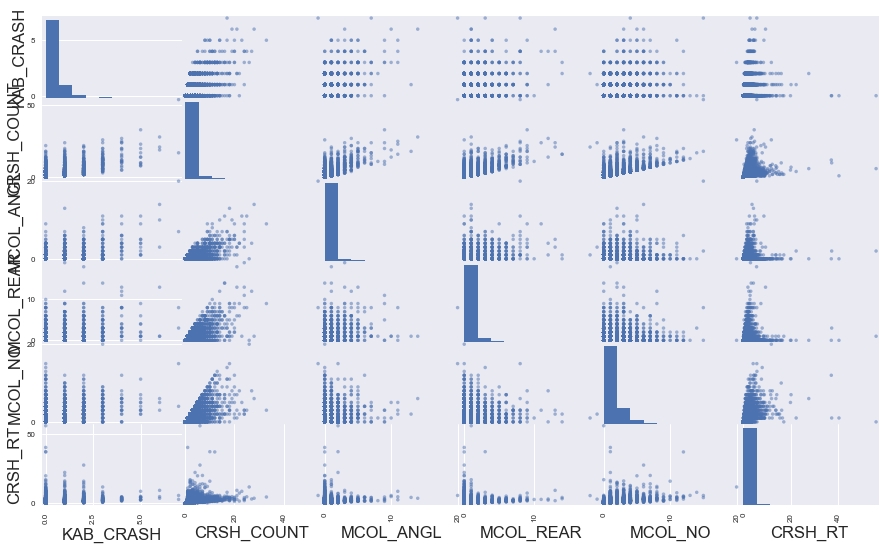

In [102]:
from pandas.plotting import scatter_matrix
# Top six correlated inputs with KAB_CRASH, ignore other crash rates.
attributes = ['KAB_CRASH','CRSH_COUNT','MCOL_ANGL','MCOL_REAR',
              'MCOL_NO','CRSH_RT']
scatter_matrix(new_data[attributes], figsize=(15, 9))

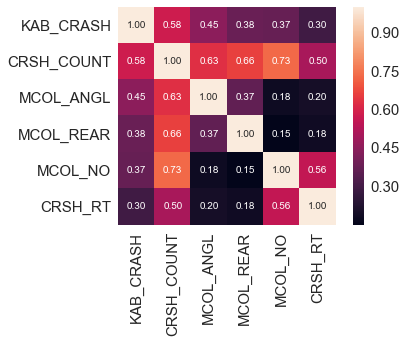

In [103]:
cm = np.corrcoef(new_data[attributes].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':10},
                yticklabels=attributes,
                xticklabels=attributes)
plt.show()

Look at a plot of the most correlated features with KAB_CRASH.

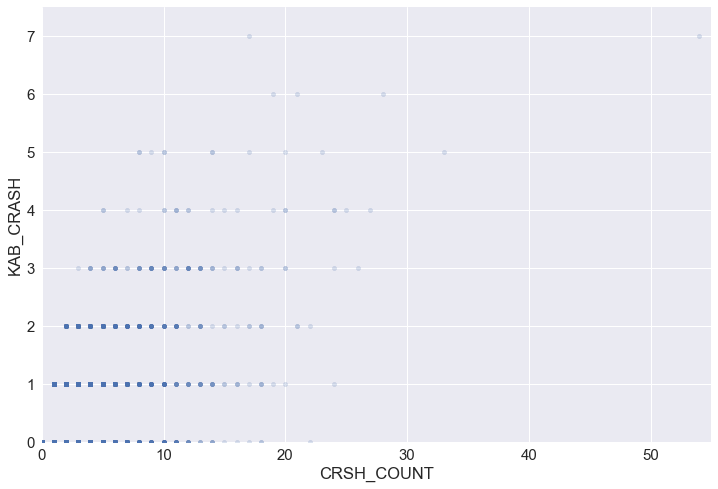

In [104]:
new_data.plot(kind="scatter", x='CRSH_COUNT', y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 55, 0, 7.5])
plt.show()

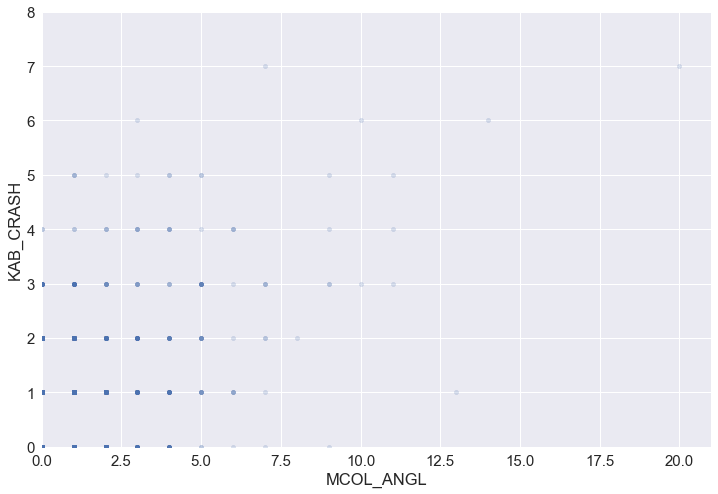

In [105]:
new_data.plot(kind="scatter", x='MCOL_ANGL', y="KAB_CRASH",
             alpha=0.2,figsize=(12,8))
plt.axis([0, 21, 0, 8])
plt.show()

## Modify previous Pipeline to inculde new features

In [106]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13370 entries, 0 to 13369
Data columns (total 35 columns):
INT_ID        13370 non-null object
IX_NAME       13370 non-null object
DOT_REGION    13370 non-null object
SKEW_ANGLE    13370 non-null float64
MAJ_LNS       13370 non-null float64
MIN_LNS       13370 non-null float64
MEDIAN_FT     13370 non-null float64
MAJOR_AADT    13370 non-null float64
MINOR_AADT    13370 non-null float64
CRSH_COUNT    13370 non-null float64
MCOL_ANGL     13370 non-null float64
MCOL_NO       13370 non-null float64
MCOL_REAR     13370 non-null float64
MCOL_SSOP     13370 non-null float64
MCOL_SSS      13370 non-null float64
MCOL_OTR      13370 non-null float64
KAB_CRASH     13370 non-null float64
TOTAL_AADT    13370 non-null float64
CRSH_RT       13370 non-null float64
LAT           13370 non-null float64
LON           13370 non-null float64
TRKYR_1       13370 non-null float64
TRWAYWD       13370 non-null int64
RSHTOTWD      13370 non-null float64
RSHPAVWD

In [107]:
from sklearn.pipeline import Pipeline, FeatureUnion

# Identify the numeric features we wish to consider. 
num_attribs = ["MIN_LNS","MAJ_LNS","MAJOR_AADT","MINOR_AADT",
               "TOTAL_AADT","CRSH_RT", "CRSH_COUNT","MCOL_ANGL","MCOL_REAR",
               "MCOL_NO", "MCOL_SSS", "MCOL_SSOP","MCOL_OTR", "LON", 
               "MEDIAN_FT", "SKEW_ANGLE", "LAT",'TRKYR_1','TRWAYWD',
               "RSHTOTWD","RSHPAVWD","RAUXWDTH","RAUX1TYP","RAUX1WD","RSH1WD","LAUXWDTH",
               "LAUX1TYP","LAUX1WD","LSHPAVWD","LSH1TYP","LSH1WD"]

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())])

# Identify the categorical features we wish to consider.
#cat_attribs = ["CONTROL","LEGS","ARTYP_FED","BYPASS_LN",
              # "SHARED_LT","MEDIAN_TYP",'DIVUND']

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
        ('imputer', CategoricalImputer()),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore")),
        ])

# Union the transformed, scaled numeric and categorical features.
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                               ("cat_pipeline", cat_pipeline)])

## Train/Test Split

Reorder the data so it is easier to select subset of columns to use for train/test.

In [108]:
xset=new_data.drop(["KAB_CRASH"],axis=1).copy()

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [109]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = xset.iloc[:,3:].copy()
y = new_data["KAB_CRASH"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [110]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

X_train (10696, 31) y_train (10696,)
X_test (2674, 31) y_test (2674,)


In [111]:
X_train_std = num_pipeline.fit_transform(X_train)
X_test_std = num_pipeline.fit_transform(X_test)

In [112]:
X_train_std[0]

array([-0.158, -0.347, -1.065, -0.175, -1.028, -0.624, -0.656, -0.262,
       -0.346, -0.654, -0.243, -0.198, -0.172, -1.187, -0.15 ,  0.262,
        1.84 , -0.583, -1.142,  0.41 , -0.166, -0.344, -0.171, -0.347,
       -0.106, -0.303, -0.147, -0.311,  0.224, -0.623,  0.153])

In [113]:
X_test_std[0]

array([-0.159, -0.36 , -0.588, -0.4  , -0.631, -0.605, -0.703, -0.261,
       -0.355, -0.666, -0.249, -0.213, -0.176, -0.63 , -0.154,  0.175,
       -0.98 ,  0.261, -0.112,  1.55 , -0.19 , -0.354, -0.176, -0.356,
       -0.148,  3.358,  0.776,  3.522, -1.076,  1.557, -1.173])

# Create a PCA model to find better results.

## PCA using scikitlearn

In [114]:
from sklearn.decomposition import PCA

pca_loadings = pd.DataFrame(PCA().fit(X_train_std).components_.T,
                            index=X.columns, columns=["V1","V2","V3","V4","V5","V6",
                                                      "V7","V8","V9","V10", "V11",
                                                      "V12","V13","V14","V15","V16",
                                                      "V17", "V18",'V19','V20',"V21",
                                                      "V22","V23","V24","V25","V26",
                                                      "V27","V28","V29","V30","V31"]
                           )
pca_loadings

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31
SKEW_ANGLE,0.025555,0.223170,-0.447481,-0.186663,0.238934,0.053851,-0.020589,0.044576,-0.008937,0.070732,...,-0.063139,0.016780,-0.033266,0.018472,0.011585,-0.719567,0.012486,0.008911,-1.079922e-15,0.000000e+00
MAJ_LNS,0.058870,0.257745,-0.325011,-0.110881,0.135956,-0.008393,-0.012415,0.018762,0.008627,0.065443,...,0.105449,-0.045655,0.023229,-0.008062,-0.007799,0.025783,-0.007321,0.000642,8.004273e-16,8.881784e-16
MIN_LNS,0.104696,0.347503,-0.135718,-0.074213,-0.283628,0.013675,0.026200,-0.114446,0.050665,-0.066669,...,0.238779,-0.018598,-0.008131,-0.003263,-0.005806,0.015374,0.000691,-0.002208,4.019182e-01,-5.397278e-01
MEDIAN_FT,0.049533,0.201208,0.110666,0.026180,-0.164101,0.254052,0.018670,0.127933,-0.152406,0.134513,...,0.024483,0.019251,0.007756,-0.003164,0.000606,-0.006994,0.000299,0.001382,9.282410e-02,-1.246516e-01
MAJOR_AADT,0.108066,0.366597,-0.102505,-0.063430,-0.299186,0.067322,0.028392,-0.079000,0.014392,-0.033129,...,0.227449,-0.013169,-0.005899,-0.003716,-0.005273,0.012802,0.000707,-0.001757,-4.319312e-01,5.800317e-01
MINOR_AADT,0.026015,0.128989,0.274745,0.108887,0.524222,-0.193298,-0.053710,-0.046203,-0.026018,-0.002798,...,0.671073,-0.005211,0.024923,0.009366,0.000530,0.002233,-0.003712,-0.000139,1.875025e-16,1.110223e-16
CRSH_COUNT,0.096455,0.378789,0.271087,0.088638,0.171621,0.013768,-0.007999,-0.010750,-0.006764,-0.037467,...,-0.282114,0.003253,-0.013575,-0.002517,0.003129,-0.002438,0.000706,0.000287,6.337311e-01,4.719196e-01
MCOL_ANGL,0.073055,0.264676,0.188706,0.057269,-0.030424,0.166056,0.011827,0.173096,-0.007758,0.051844,...,0.066168,0.001977,0.007109,0.008240,-0.000062,0.000768,-0.003127,-0.000267,-1.816240e-01,-1.352497e-01
MCOL_NO,0.078569,0.265368,0.201777,0.040133,-0.162376,0.137897,0.009802,-0.029511,-0.027718,-0.077871,...,-0.130324,0.001447,0.000012,-0.001650,0.002617,-0.011795,0.000896,0.003267,-2.440939e-01,-1.817691e-01
MCOL_REAR,0.051294,0.245830,0.147625,0.074566,0.452168,-0.207384,-0.029819,-0.126382,0.008870,-0.045614,...,-0.417938,0.005702,-0.027847,-0.006051,0.003351,0.002612,0.003592,-0.000999,-3.631635e-01,-2.704364e-01


In [115]:
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X_train_std), 
                       columns=['PC1', 'PC2', 'PC3','PC4','PC5','PC6',
                               'PC7', 'PC8', 'PC9','PC10','PC11','PC12',
                               'PC13', 'PC14', 'PC15','PC16','PC17','PC18',
                               'PC19', 'PC20', 'PC21','PC22','PC23','PC24',
                               'PC25', 'PC26', 'PC27','PC28','PC29','PC30',
                               'PC31'],index=X_train.index)
df_plot.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
414,-1.516951,-1.843060,-0.068106,-0.225838,0.526378,1.595500,0.425163,1.202737,-0.324902,-0.455831,...,-0.290825,0.022730,0.329071,0.115170,0.117798,-0.038562,0.013786,-0.001003,-1.646731e-14,2.731525e-15
6545,-1.069483,1.593281,0.942130,0.665601,1.634995,-2.132105,-0.246649,-0.841051,0.282714,-0.679386,...,-1.074407,0.058855,0.934015,-0.201341,-0.506626,-0.000446,0.015157,-0.013118,9.261621e-14,9.552118e-15
8862,-0.395340,0.126070,-0.455460,-0.816661,-1.521527,0.459300,0.350010,-0.600852,0.662143,0.454547,...,0.731657,-0.072789,-0.446236,-0.603272,0.068451,0.043919,0.007514,-0.003559,-5.460036e-14,9.343577e-15
10335,1.254749,-2.025619,1.208493,-1.700301,1.965410,1.002367,0.040701,0.411360,-0.132989,-0.614818,...,0.066218,0.027415,-0.349575,-0.046718,-0.078285,-0.028034,0.004369,-0.004541,2.502203e-14,-6.374531e-15
4501,-0.565306,2.576824,1.102800,0.430070,-0.163964,0.305364,0.233577,-2.249875,1.722923,0.254136,...,-0.521800,-0.088968,-0.518757,0.020192,-0.001052,0.047307,0.006898,-0.001445,3.710823e-15,4.648838e-16


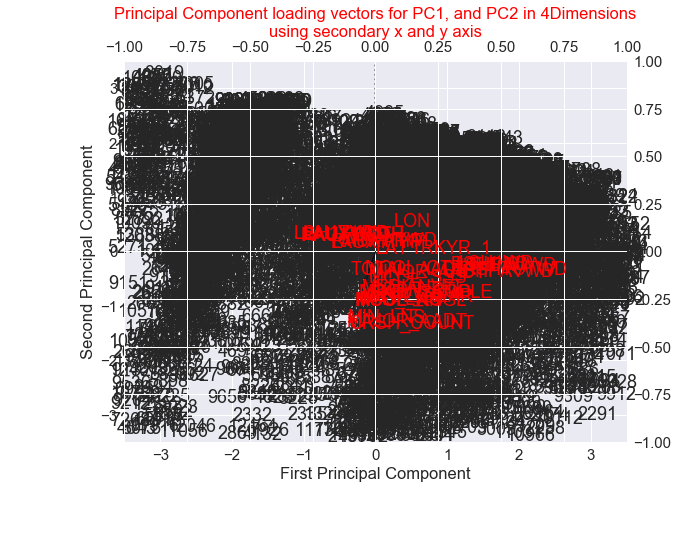

In [116]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
#plot the loadings of the first PC and second PC (2 by 4 matrix)
ax2.set_xlabel('Principal Component loading vectors for PC1, and PC2 in 4Dimensions\nusing secondary x and y axis', color='red')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (-pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='red')

# Plot vectors
ax2.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V2[3])

In [117]:
pca.explained_variance_

array([ 5.396,  4.572,  2.467,  2.358,  1.562,  1.294,  1.216,  1.07 ,
        1.025,  0.997,  0.933,  0.924,  0.898,  0.875,  0.801,  0.761,
        0.65 ,  0.613,  0.541,  0.444,  0.371,  0.358,  0.321,  0.268,
        0.116,  0.078,  0.048,  0.026,  0.018,  0.   ,  0.   ])

In [118]:
pca.explained_variance_ratio_

array([ 0.174,  0.147,  0.08 ,  0.076,  0.05 ,  0.042,  0.039,  0.035,
        0.033,  0.032,  0.03 ,  0.03 ,  0.029,  0.028,  0.026,  0.025,
        0.021,  0.02 ,  0.017,  0.014,  0.012,  0.012,  0.01 ,  0.009,
        0.004,  0.003,  0.002,  0.001,  0.001,  0.   ,  0.   ])

We see that the first principal component explains 17% of the variance
in the data, the next principal component explains 15% of the variance,the next principal component explains 8% of the variance, the next principal component explains 8% of the variance,the next principal component explains 5% of the variance, and so forth. We can plot the PVE explained by each component as follows:

([<matplotlib.axis.XTick at 0x1a2637aa20>,
 <a list of 31 Text xticklabel objects>)

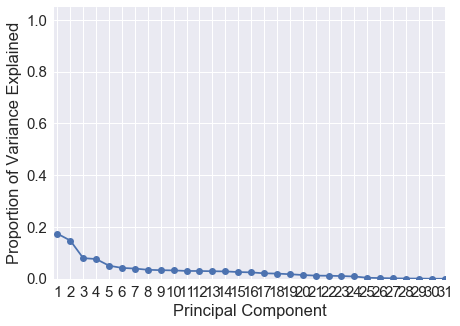

In [119]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
          23,24,25,26,27,28,29,30,31], pca.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31])

Look at the cumulative sum of the elements of the cumulative PVE.

([<matplotlib.axis.XTick at 0x1a28b82550>,
 <a list of 31 Text xticklabel objects>)

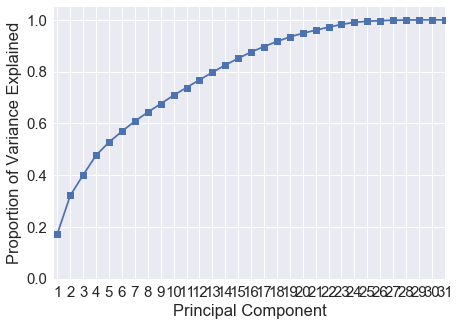

In [120]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,
            23,24,25,26,27,28,29,30,31])

However, none of this information really helps with this evaluation. It is nice to know, but since we are looking at coming up wiht a regression model, the results of this do not give us any additional insight.

# Decision Tree

In [121]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=6, 
                              random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [122]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Fit regression model
tree_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=5,random_state=42)
tree_reg1.fit(X_train, y_train)
tree_reg2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [123]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_train, y_train)
tree_reg2.fit(X_train, y_train)

x1 = X_test
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

In [124]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg2,
        out_file="kab_tree2.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )
export_graphviz(
        tree_reg1,
        out_file="kab_tree1.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )

export_graphviz(
        tree_reg,
        out_file="kab_tree.dot",
        feature_names=X_train.columns,
        class_names=X_train.index,
        rounded=True,
        filled=True
    )

# Bagging

In [125]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(
    RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42))

# Best estimator fitting time
t0 = time()
bag_reg.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
ytr_pred_rf = bag_reg.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred_rf = bag_reg.predict(X_test_std)
time_test = round(time() - t0,2)

In [126]:
rf_test_score = mean_squared_error(y_test, y_pred_rf)
rf_train_score = mean_squared_error(y_train, ytr_pred_rf)
rf_train_score

0.1805758440277293

In [127]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores, rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = bag_reg.get_params()
print(best_parameters)

# Record the results
results.loc[9] = ["Bagged RandomForest", rf_train_score, np.sqrt(rf_train_score),
                  rf_test_score, np.sqrt(rf_test_score), #round(p_value,3),
                  "---", time_train, time_test, best_parameters]
results

Best Parameters:
{'base_estimator__bootstrap': True, 'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': 'auto', 'base_estimator__max_leaf_nodes': 16, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 500, 'base_estimator__n_jobs': -1, 'base_estimator__oob_score': False, 'base_estimator__random_state': 42, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=16,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=42, verb

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,4.424738e-02,2.103506e-01,-9.042482e-01,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,5.790299e-03,7.609401e-02,-9.962042e-01,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,8.330492e-02,2.886259e-01,-7.285754e-01,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,1.805758e-01,4.249422e-01,1.890559e-01,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


This Bagged RandomForest Model gave us much better results going to 0.43707 RMSE on the test set.

In [128]:
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

# Best estimator fitting time
t0 = time()
bag_reg.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
ytr_pred_dt = bag_reg.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred_dt = bag_reg.predict(X_test_std)
time_test = round(time() - t0,2)

In [129]:
rf_test_score = mean_squared_error(y_test, y_pred_dt)
rf_train_score = mean_squared_error(y_train, ytr_pred_dt)

In [130]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = bag_reg.get_params()
print(best_parameters)

# Record the results
results.loc[10] = ["Bagged Decision Tree", rf_train_score, np.sqrt(rf_train_score),
                   rf_test_score, np.sqrt(rf_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

Best Parameters:
{'base_estimator__criterion': 'mse', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': 16, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': False, 'base_estimator__random_state': 42, 'base_estimator__splitter': 'random', 'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=16, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='random'), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, '

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.631304e+20,1.905598e+10,-6.467879e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,4.424738e-02,2.103506e-01,5.496759e-02,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,8.334085e-02,2.886882e-01,8.340403e-02,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,5.204958e-03,7.214539e-02,-9.973864e-01,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,8.336076e-02,2.887226e-01,-7.283879e-01,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,8.499435e-02,2.915379e-01,-7.249504e-01,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,4.424738e-02,2.103506e-01,-9.042482e-01,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,5.790299e-03,7.609401e-02,-9.962042e-01,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,8.330492e-02,2.886259e-01,-7.285754e-01,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,1.805758e-01,4.249422e-01,1.890559e-01,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


This Bagged Decision Tree Model gave us slightly better results of 0.434 RMSE on the test set, just slightly better than that of the Bagged Random Forest above.

The predictions were within .02% of one another.

In [131]:
np.sum(abs(y_pred_dt - y_pred_rf)<0.20) / len(y_pred_dt)  # almost identical predictions

0.98765893792071802

# Gradient Boosting 

In [132]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train_std, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

** Now train a second DecisionTreeRegressor on the residual errors made by the first
predictor:**

In [133]:
y2_train = y_train - tree_reg1.predict(X_train_std)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X_train_std, y2_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

** Now train a third DecisionTreeRegressor on the residual errors made by the first
predictor:**

In [134]:
y3_train = y2_train - tree_reg2.predict(X_train_std)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X_train_std, y3_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [135]:
y_pred = sum(tree.predict(X_test_std) for tree in (tree_reg1, tree_reg2, tree_reg3))

### Prediction using GBDT model
Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [136]:
y_pred

array([-0.016,  1.497, -0.016, ...,  0.689,  0.422, -0.016])

Calculate Mean Squared Error on prediction vs. test

In [137]:
error = mean_squared_error(y_test, y_pred)
error

0.22024769688011281

In [138]:
# Record the results
results.loc[11] = ["GradientBoost Decision Tree", "---", error, 
                   "---", np.sqrt(error),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.6313e+20,1.905598e+10,-6.46788e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,0.0442474,2.103506e-01,0.0549676,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,0.0833409,2.886882e-01,0.083404,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,0.00520496,7.214539e-02,-0.997386,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,0.0833608,2.887226e-01,-0.728388,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,0.0849943,2.915379e-01,-0.72495,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,0.0442474,2.103506e-01,-0.904248,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,0.0057903,7.609401e-02,-0.996204,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,0.0833049,2.886259e-01,-0.728575,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,0.180576,4.249422e-01,0.189056,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


### Gradient Boosting via Scikit-Learn

#### Fast

In [139]:
xset=new_data.drop(["KAB_CRASH"],axis=1).copy()

Split the data prior to feature visualization and engineering in order to prevent test data from influencing choices:

In [140]:
from sklearn.model_selection import train_test_split
#leave out INT_ID, IX_NAME, DOT_REGION, and KAB_CRASH
X = xset.iloc[:,3:].copy()
y = new_data["KAB_CRASH"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [141]:
print ("X_train", X_train.shape, "y_train", y_train.shape)
print ("X_test", X_test.shape, "y_test", y_test.shape)

X_train (10696, 31) y_train (10696,)
X_test (2674, 31) y_test (2674,)


In [142]:
X_train_std = num_pipeline.fit_transform(X_train)
X_test_std = num_pipeline.fit_transform(X_test)

In [143]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
# Best estimator fitting time
t0 = time()
gbrt.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
gbrt_tr_pred = gbrt.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred = gbrt.predict(X_test_std)
time_test = round(time() - t0,2)

In [144]:
gbrt_test_score = mean_squared_error(y_test, y_pred)
gbrt_train_score = mean_squared_error(y_train, gbrt_tr_pred)

In [146]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = gbrt.get_params()
print(best_parameters)

# Record the results
results.loc[12] = ["Grad Boost Regressor Fast", gbrt_train_score, np.sqrt(gbrt_train_score),
                   gbrt_test_score, np.sqrt(gbrt_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

Best Parameters:
{'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1.0, 'loss': 'ls', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'presort': 'auto', 'random_state': 42, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.6313e+20,1.905598e+10,-6.46788e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,0.0442474,2.103506e-01,0.0549676,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,0.0833409,2.886882e-01,0.083404,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,0.00520496,7.214539e-02,-0.997386,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,0.0833608,2.887226e-01,-0.728388,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,0.0849943,2.915379e-01,-0.72495,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,0.0442474,2.103506e-01,-0.904248,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,0.0057903,7.609401e-02,-0.996204,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,0.0833049,2.886259e-01,-0.728575,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,0.180576,4.249422e-01,0.189056,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."


In [147]:
X_train_std

array([[-0.158, -0.347, -1.065, ...,  0.224, -0.623,  0.153],
       [-0.158, -0.347,  0.135, ...,  0.657, -0.134,  0.603],
       [-0.158, -0.347,  1.431, ...,  0.224, -0.623,  0.153],
       ..., 
       [-0.158, -0.347,  0.599, ...,  0.657, -0.623,  0.603],
       [-0.158, -0.347, -1.142, ...,  1.522, -0.134,  1.502],
       [-0.158, -0.347,  3.146, ...,  1.089, -0.134,  1.053]])

#### Slow

In [148]:
gbrt_slow = GradientBoostingRegressor(max_depth=3, n_estimators=200, learning_rate=0.1, random_state=42)

# Best estimator fitting time
t0 = time()
gbrt_slow.fit(X_train_std, y_train)
time_train = round(time() - t0,2)
gbrt_tr_pred = gbrt_slow.predict(X_train_std)

# Best estimator prediction time
t0 = time()
y_pred = gbrt_slow.predict(X_test_std)
time_test = round(time() - t0,2)

In [149]:
gbrt_test_score = mean_squared_error(y_test, y_pred)
gbrt_train_score = mean_squared_error(y_train, gbrt_tr_pred)

In [150]:
# Conduct t-test with baseline linear (control) and best estimator (experiment)
#(t_stat, p_value) = stats.ttest_rel(linreg_scores.mean(), rf_train_score)

# Collect the best parameters found by the grid search
print("Best Parameters:")
best_parameters = gbrt_slow.get_params()
print(best_parameters)

# Record the results
results.loc[13] = ["Grad Boost Regressor Slow", gbrt_train_score, np.sqrt(gbrt_train_score),
                   gbrt_test_score, np.sqrt(gbrt_test_score),#round(p_value,3), 
                   "---", time_train, time_test, best_parameters]
results

Best Parameters:
{'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'presort': 'auto', 'random_state': 42, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


,ExpID,Train MSE,Train RMSE,Test MSE,Test RMSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Linear Baseline,-3.6313e+20,1.905598e+10,-6.46788e+20,2.543202e+10,---,< 1s,< 1s,Untuned LinearRegression
1,SVR Crossval,0.0442474,2.103506e-01,0.0549676,2.344517e-01,0.005,< 1s,< 1s,CV SupportVectorRegressor
2,Ridge Crossval,0.0833409,2.886882e-01,0.083404,2.887976e-01,0.005,< 1s,< 1s,CV RidgeRegression
3,Tuned RandomForest,0.00520496,7.214539e-02,-0.997386,NaN,0.005,0.75,0.01,"{'bootstrap': False, 'criterion': 'mse', 'max_..."
4,Tuned Ridge,0.0833608,2.887226e-01,-0.728388,NaN,0.005,0.01,0,"{'alpha': '0.00002', 'copy_X': True, 'fit_inte..."
5,Tuned SGD,0.0849943,2.915379e-01,-0.72495,8.514402e-01,0.005,0.18,0,"{'alpha': 1e-06, 'average': False, 'epsilon': ..."
6,Tuned SVR,0.0442474,2.103506e-01,-0.904248,9.509197e-01,0.005,1.28,0.18,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd..."
7,RandomSearch RndForest,0.0057903,7.609401e-02,-0.996204,9.981003e-01,0.005,2.69,0.03,"{'bootstrap': True, 'criterion': 'mse', 'max_d..."
8,RandomSearch Ridge,0.0833049,2.886259e-01,-0.728575,8.535663e-01,0.005,0.01,0,"{'alpha': 8, 'copy_X': True, 'fit_intercept': ..."
9,Bagged RandomForest,0.180576,4.249422e-01,0.189056,4.348056e-01,---,66.42,2.2,"{'base_estimator__bootstrap': True, 'base_esti..."
